# AQI comparison

This notebook compares the values of the air quality index recorded by the government monitor in the city centre and the CSL monitor.

A description of the air quality index used can be found [here](https://en.wikipedia.org/wiki/Air_quality_index#United_States).

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import aqi

%matplotlib inline

# Data preparation

## City centre

These AQI values were calculated by the World Air Quality Index Project using data recorded by the Welsh Government (Air Quality In Wales) in Cardiff city centre.

In [20]:
centre_data = pd.read_csv("data/cardiff_centre_AQI.csv")
centre_data['date'] = pd.to_datetime(centre_data['date'])
centre_data = centre_data.set_index('date')
centre_data = centre_data.sort_index()
cols = [' pm25', ' pm10', ' o3', ' no2', ' so2', ' co']
centre_data[cols] = centre_data[cols].apply(pd.to_numeric, errors='coerce')
centre_data['centre_index'] = centre_data[cols].max(axis=1)
centre_data = centre_data.drop(cols, axis=1)
centre_data = centre_data.loc['2020-06-23':'2021-01-13']
centre_data.tail()

,centre_index
date,
2021-01-09,54.0
2021-01-10,57.0
2021-01-11,64.0
2021-01-12,31.0
2021-01-13,30.0


## CSL

In [21]:
csl_data = pd.read_csv("data/csl_data.csv")
cols = [c for c in csl_data.columns if 'AQI' not in c]
csl_data = csl_data[cols]
csl_data['timestamp'] = pd.to_datetime(csl_data['timestamp'],unit='s')
csl_data = csl_data.set_index('timestamp')
def conv_to_aqi(row):
    return int(aqi.to_aqi([
        (aqi.POLLUTANT_PM25, row.PM2_5),
        (aqi.POLLUTANT_PM10, row.PM10_0),
        (aqi.POLLUTANT_NO2_1H, row.NO2),
        (aqi.POLLUTANT_CO_8H, row.CO)
    ]))
csl_data = csl_data.resample('D').mean()
csl_data = csl_data.dropna()
csl_data['csl_index'] = csl_data.apply(conv_to_aqi, axis=1)
csl_data = pd.DataFrame(csl_data['csl_index'])
csl_data = csl_data.loc['2020-06-23':'2021-01-13']
csl_data.head()

,csl_index
timestamp,
2020-06-23,20
2020-06-24,40
2020-06-25,55
2020-06-26,48
2020-06-27,8


## Joining the data

In [22]:
data = centre_data.join(csl_data)
data.head()

,centre_index,csl_index
date,,
2020-06-23,57.0,20.0
2020-06-24,54.0,40.0
2020-06-25,50.0,55.0
2020-06-26,37.0,48.0
2020-06-27,23.0,8.0


# Visualisations

## Line graph

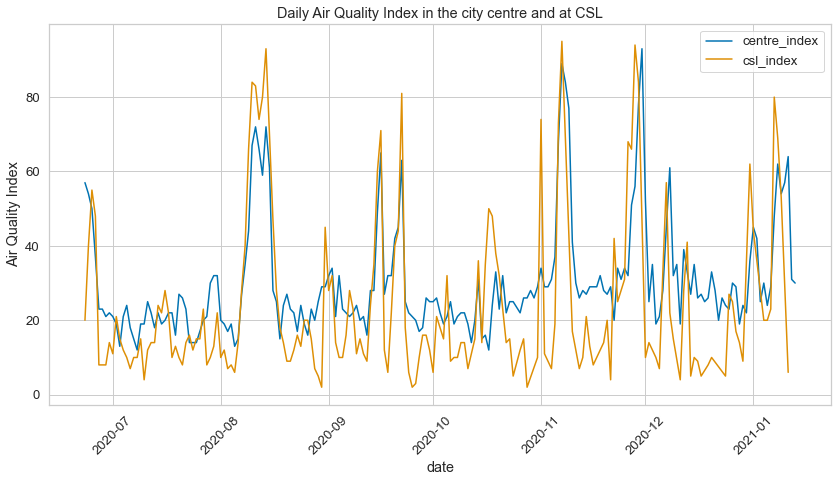

In [23]:
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")
sns.set_palette("colorblind")

plt.figure(figsize=(14, 7))
sns.lineplot(data=data, dashes=False)
plt.title("Daily Air Quality Index in the city centre and at CSL")
plt.ylabel("Air Quality Index")
plt.xticks(rotation=45);

We can see here that the air quality at the school seems to generally be better than the air quality in the city centre, although they are both generally low. However, they do sometimes spike.

## Correlation coefficient

In [24]:
corr = data['csl_index'].corr(data['centre_index'])
print('Pearson correlation coefficient:', corr)

Pearson correlation coefficient: 0.7512887736247738


The Perason correlation coefficient measures the strength of a correlation between two variables, with 1 being a perfect positive correlation and -1 being a perfect negative correlation.

The high value of the measure suggests that the averages of the readings of the two monitors are correlated together.

## Scatter graph

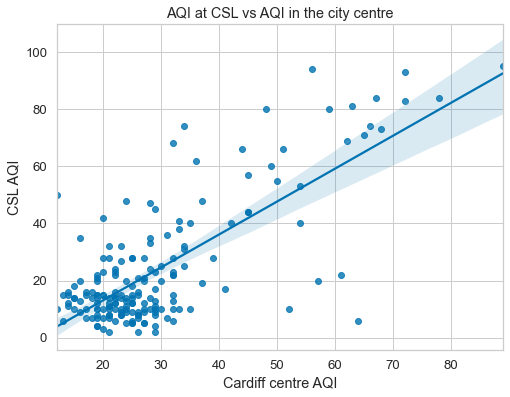

In [25]:
plt.figure(figsize=(8, 6))
sns.regplot(data=data, x='centre_index', y='csl_index')
plt.title("AQI at CSL vs AQI in the city centre")
plt.xlabel("Cardiff centre AQI")
plt.ylabel("CSL AQI");

## Histogram

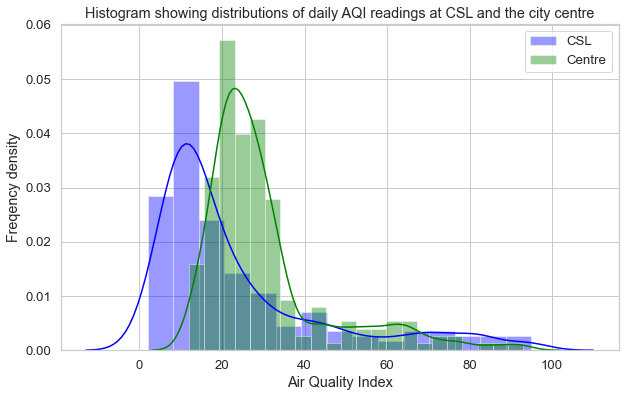

In [26]:
plt.figure(figsize=(10, 6))
sns.distplot(a=data['csl_index'], color='blue', label='CSL')
sns.distplot(a=data['centre_index'], color='green', label='Centre')
plt.ylabel("Freqency density")
plt.xlabel("Air Quality Index")
plt.title("Histogram showing distributions of daily AQI readings at CSL and the city centre")
plt.legend();

The histogram shows that the median for the air quality index at CSL is lower than the median for the city centre. This may be because Llandaff is a more residential area than the city centre and is hence likely to have less road traffic.

The median for both locations is within the 'good' range of the AQI below 50. However, they both have long tails that mean they sometimes enter the 'moderate' range of 51 to 100.

## AQI categories bar chart

In [58]:
data['csl'] = pd.cut(data['csl_index'], [-1, 50, 100, 150, 200, 300],
                              labels=['Good','Moderate','Unhealthy for sensitive groups',
                                     'Unhealthy','Very unhealthy'])
data['centre'] = pd.cut(data['centre_index'], [-1, 50, 100, 150, 200, 300],
                              labels=['Good','Moderate','Unhealthy for sensitive groups',
                                     'Unhealthy','Very unhealthy'])
bar_data = data[['csl','centre']]
bar_data = pd.melt(bar_data, var_name='location', value_name='category').reset_index()
bar_data = bar_data.groupby(['location','category']).count()
bar_data = bar_data.div(bar_data.groupby('location').sum(), axis='index', level='location')*100
bar_data = bar_data.reset_index()

bar_data.head()

,location,category,index
0,centre,Good,88.235294
1,centre,Moderate,11.764706
2,csl,Good,87.912088
3,csl,Moderate,12.087912


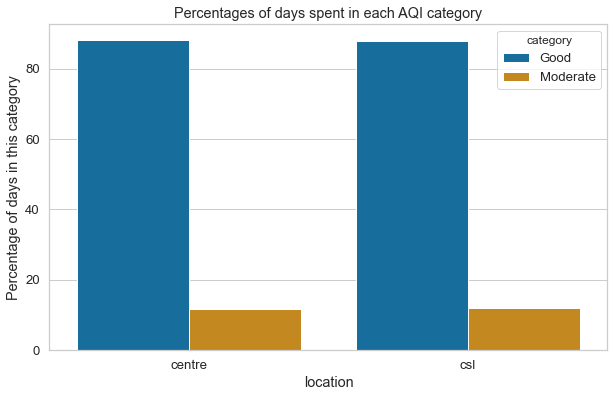

In [60]:
plt.figure(figsize=(10, 6))
g=sns.barplot(x="location", y="index", hue="category", data=bar_data)
plt.title('Percentages of days spent in each AQI category')
plt.ylabel('Percentage of days in this category');